In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from scipy.stats import randint as sp_randint

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

In [3]:
base_dataset = pd.read_hdf('/home/dissertation/data/feat_eng_abt.h5', 'feat_eng_abt')
base_dataset.drop(['transaction_date_min', 'transaction_date_max'], axis = 1, inplace=True)
base_dataset['city'] = base_dataset.city.astype(str)
base_dataset['registered_via'] = base_dataset.registered_via.astype(str)

base_dataset.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,registration_init_time_dt,age_cat,total_order,...,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,actual_amount_mean,total_actual_amount,is_auto_renew_mode,cancel_times,transaction_date_delta
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,20131223,2013-12-23,28,6,...,2,0,10.00,49.67,298.00,149.00,894.00,True,1,700.00
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20,male,3,20131223,2013-12-23,20,5,...,3,30,25.40,125.40,627.00,125.40,627.00,False,0,344.00
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18,male,3,20131227,2013-12-27,18,18,...,1,30,30.00,149.00,2682.00,149.00,2682.00,False,0,530.00
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0,unknown,7,20140109,2014-01-09,0,19,...,2,30,25.63,125.47,2384.00,141.16,2682.00,True,3,413.00
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35,female,7,20140125,2014-01-25,35,24,...,1,30,26.25,105.38,2529.00,123.17,2956.00,True,2,586.00


In [4]:
## Simple Data Prep 
base_dataset = base_dataset.drop(labels =['msno', 'bd'], axis=1)

## Simply drops records with NA ast this stage
base_dataset = clean_dataset(base_dataset)

print(base_dataset.shape)
base_dataset.head()

(858935, 19)


,is_churn,city,gender,registered_via,registration_init_time,registration_init_time_dt,age_cat,total_order,payment_method_id_mode,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,actual_amount_mean,total_actual_amount,is_auto_renew_mode,cancel_times,transaction_date_delta
0,1,5,male,3,20131223,2013-12-23,28,6,31,2,0,10.00,49.67,298.00,149.00,894.00,True,1,700.00
1,1,13,male,3,20131223,2013-12-23,20,5,38,3,30,25.40,125.40,627.00,125.40,627.00,False,0,344.00
2,1,13,male,3,20131227,2013-12-27,18,18,38,1,30,30.00,149.00,2682.00,149.00,2682.00,False,0,530.00
3,1,1,unknown,7,20140109,2014-01-09,0,19,41,2,30,25.63,125.47,2384.00,141.16,2682.00,True,3,413.00
4,1,13,female,7,20140125,2014-01-25,35,24,41,1,30,26.25,105.38,2529.00,123.17,2956.00,True,2,586.00


In [5]:
import sklearn 
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
## WHAT METRIC SHOULD BE OPTIMSED AS PART OF CV

In [9]:
RANDOM_STATE = 42 
CV_ITER = 3
SCORING_METRIC = 'recall'

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]


classifiers = [
        ('NB', GaussianNB(), {}, 
               SCORING_METRIC),    
        ('DT', DecisionTreeClassifier(), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                         "criterion": ["entropy"], 
                         "max_depth":sp_randint(10,30), 
                         "min_samples_leaf":sp_randint(10,50),
                         "min_samples_split":sp_randint(10,100),
                         "class_weight":[None, "balanced"],
                         "presort" : [True, False]}, 
               SCORING_METRIC),    
        ('RF', RandomForestClassifier(n_jobs =-1), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                         "criterion": ["entropy","gini"], 
                         "n_estimators": sp_randint(100,200),
                         "max_depth":sp_randint(10,30), 
                         "min_samples_leaf":sp_randint(10,50),
                         "min_samples_split":sp_randint(10,100),
                         "class_weight":[None, "balanced"]},
               SCORING_METRIC),    
        ('LR', LogisticRegression(), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                         "solver" : ['newton-cg', 'lbfgs', 'liblinear','saga'],
                         "class_weight": [None, "balanced"],
                         "max_iter": sp_randint(10,100),
                         "C": sp_randint(1,10)}, 
               SCORING_METRIC),
        ('AB', AdaBoostClassifier(), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                         "n_estimators": sp_randint(300,800),
                        }, 
                SCORING_METRIC),
        ('MLP', MLPClassifier(), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                         "hidden_layer_sizes": [(50,), (100,)],
                         "activation": ["tanh", "relu"],
                         "solver": ["adam"],
                         "alpha": [0.0001, 0.001, 0.01]}, 
                SCORING_METRIC),
        ('XGB', xgb.XGBClassifier(objective="binary:logistic", n_jobs=8), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                         "n_estimators": sp_randint(100,200),
                         "max_depth":sp_randint(1,6),
                         "learning_rate": [0.0001, 0.001, 0.01]
                         }, SCORING_METRIC) 
]

In [7]:
all_metrics = pd.DataFrame()
all_metrics

""


In [ ]:
sample_dataset = base_dataset.sample(50000)

### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0
PRE-SAMPLING: (601254, 18) (601254,) Counter({0: 545044, 1: 56210})
POST-SAMPLING: (601254, 18) (601254,) Counter({0: 545044, 1: 56210})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via', 'gender']
Categorical columns in dataset ['city', 'registered_via', 'gender']
X_train:  (601254, 41) (601254, 1)
X_test:  (257681, 41) (257681, 1)


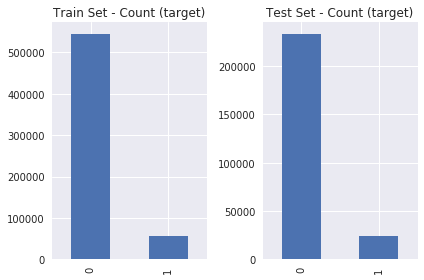

Building NB classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
Building DT classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.0min finished


CLF: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 24, 'min_samples_split': 79, 'presort': True}
Performing 3-fold CV on test set using recall metric
Building RF classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.8min finished


CLF: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 28, 'min_samples_leaf': 19, 'min_samples_split': 58, 'n_estimators': 196}
Performing 3-fold CV on test set using recall metric
Building LR classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CLF: {'C': 1, 'class_weight': 'balanced', 'max_iter': 32, 'solver': 'liblinear'}
Performing 3-fold CV on test set using recall metric
Building AB classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 85.5min finished


CLF: {'n_estimators': 949}
Performing 3-fold CV on test set using recall metric
Building MLP classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 26.4min finished


CLF: {'solver': 'adam', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}
Performing 3-fold CV on test set using recall metric
Building XGB classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.7min finished


CLF: {'learning_rate': 0.0001, 'max_depth': 5, 'n_estimators': 144}
Performing 3-fold CV on test set using recall metric


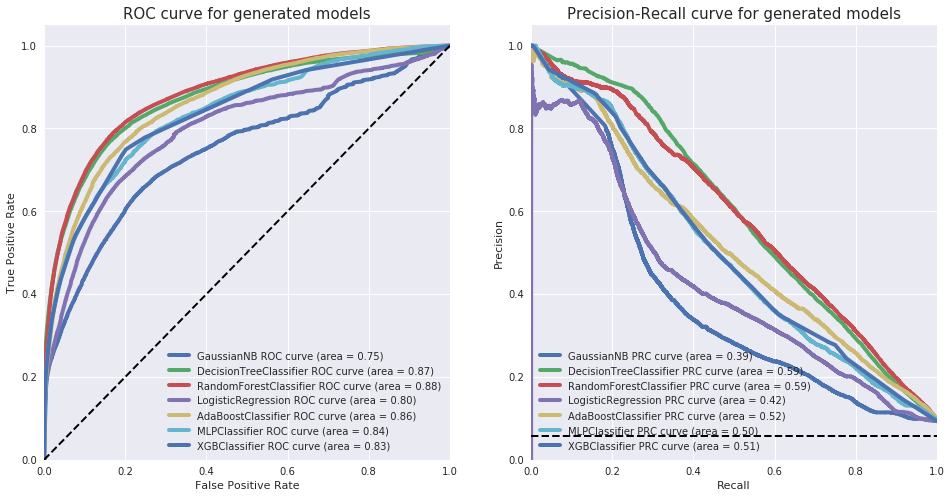

CPU times: user 1h 42min 51s, sys: 5min 58s, total: 1h 48min 49s
Wall time: 3h 22min 37s


In [8]:
%%time
sampler = ('None', DummySampler())

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, 
                                 cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

Model Build Iteration 0
PRE-SAMPLING: (601254, 18) (601254,) Counter({0: 545044, 1: 56210})
POST-SAMPLING: (1090088, 18) (1090088,) Counter({1: 545044, 0: 545044})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via', 'gender']
Categorical columns in dataset ['city', 'registered_via', 'gender']
X_train:  (1090088, 41) (1090088, 1)
X_test:  (257681, 41) (257681, 1)


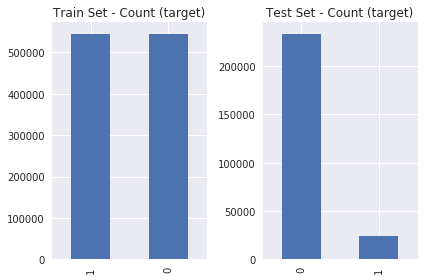

Building NB classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
Building DT classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 67.8min finished


CLF: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 28, 'min_samples_leaf': 12, 'min_samples_split': 13, 'presort': True}
Performing 3-fold CV on test set using recall metric
Building RF classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.6min finished


CLF: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 26, 'min_samples_leaf': 15, 'min_samples_split': 45, 'n_estimators': 118}
Performing 3-fold CV on test set using recall metric
Building LR classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.5min finished
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


CLF: {'C': 8, 'class_weight': None, 'max_iter': 16, 'solver': 'newton-cg'}
Performing 3-fold CV on test set using recall metric
Building AB classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 132.3min finished


CLF: {'n_estimators': 746}
Performing 3-fold CV on test set using recall metric
Building MLP classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 62.1min finished


CLF: {'solver': 'adam', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}
Performing 3-fold CV on test set using recall metric
Building XGB classifier
Optimising using RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.7min finished


CLF: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 189}
Performing 3-fold CV on test set using recall metric


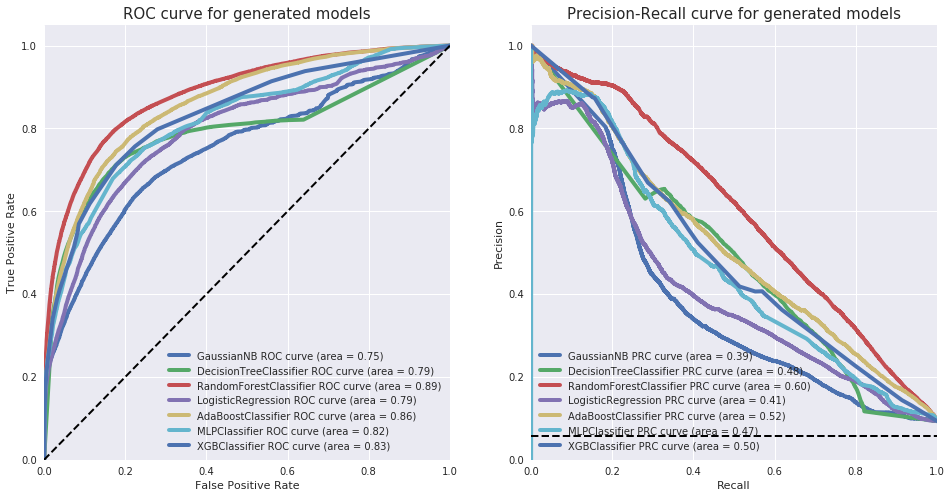

CPU times: user 2h 10min 37s, sys: 5min 55s, total: 2h 16min 32s
Wall time: 6h 28min 52s


In [10]:
%%time
sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

In [ ]:
all_metrics

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'gender', 'age_cat', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times','transaction_date_delta']

exp_metrics = perform_experiment(base_dataset[cols], classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

In [ ]:
all_metrics.sort_values('recall', ascending=False)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)